In [1]:
import sys
import numpy as np
import math as math
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
#import contextily as ctx
#from scipy.stats.stats import pearsonr
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
#from sklearn import metrics
#from sklearn.metrics import mean_squared_log_error

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# #API REQUEST
# #!/usr/bin/env python

# # make sure to install these packages before running:
# # pip install pandas
# # pip install sodapy

# import pandas as pd
# from sodapy import Socrata

# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("data.austintexas.gov", 'O83OVoUZsV65dOxldd2Hw0SK6')

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(data.austintexas.gov,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.

# dataset_id = "7d8e-dm7r"
# query = "select device_id, modified_date, vehicle_type, trip_duration, trip_distance, start_time,\
#          end_time, census_geoid_start, census_geoid_end where month = 1 limit 1000"

# query2 = "select count(*) group by month where"
# results = client.get(dataset_id, query=query2)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)


In [3]:
#Set variable types to make reading the file faster
#Trip Duration is in seconds and Trip Distance is in meters
#Most companies charge based on time
dtype_dict = {'ID' : 'str',
              'Device ID': 'str',
              'Vehicle Type': 'str',
              'Trip Duration': 'float',
              'Trip Distance': 'float',
              'Start Time': 'str',
              'End Time': 'str',
              'Modified Date': 'str',
              'Month': 'str',
              'Hour': 'str',
              'Day of Week': 'str',
              'Council District (Start)': 'str',
              'Council District (End)': 'str',
              'Year': 'str',
              'Census Tract Start': 'str',
              'Census Tract End': 'str'
             }
print(dtype_dict)

{'ID': 'str', 'Device ID': 'str', 'Vehicle Type': 'str', 'Trip Duration': 'float', 'Trip Distance': 'float', 'Start Time': 'str', 'End Time': 'str', 'Modified Date': 'str', 'Month': 'str', 'Hour': 'str', 'Day of Week': 'str', 'Council District (Start)': 'str', 'Council District (End)': 'str', 'Year': 'str', 'Census Tract Start': 'str', 'Census Tract End': 'str'}


In [4]:
#load data and set index
df = pd.read_csv('Shared_Micromobility_Vehicle_Trips.csv', index_col = 'ID', dtype = dtype_dict)
df_backup = df


In [5]:
#Change datatypes to make operations faster
#df[['Trip Duration', 'Trip Distance', 'Month', 'Hour', 'Day of Week', 'Council District (Start)', 'Council District (End)', 'Year']] =df[['Trip Duration', 'Trip Distance', 'Month', 'Hour', 'Day of Week', 'Council District (Start)', 'Council District (End)', 'Year']].astype('float32')
df[['Trip Duration', 'Trip Distance', 'Hour', 'Month', 'Year']] =df[['Trip Duration', 'Trip Distance', 'Hour', 'Month', 'Year']].astype('float32')


In [6]:
#Convert Modified Date to a datetime type
df['Datetime_Start'] = pd.to_datetime(df['Start Time'])
df['Datetime_End'] = pd.to_datetime(df['End Time'])

In [18]:
#Getting rid of some nulls and zero
df_notnull = df[df['Trip Duration'].notna()]
df = df_notnull
#only got rid of one

# There are durations and distances with negative times. They have positive distances and times respectfully
# so let's flip the signs
# df_neg = df[df['Trip Duration'] < 0]
# df_neg.head(50)
def makepos(x):
    if x>0:
        return x
    else:
        return x*-1

df['Trip Duration'] = df['Trip Duration'].apply(lambda x: makepos(x))
df['Trip Distance'] = df['Trip Distance'].apply(lambda x: makepos(x))

# Cleaning outliers
# Trips over 6 hours (average charge length) will be removed --  21600s
# The max speed is 15 mph, so no trips longer than (15mph * 6hours) * 1609m/mile = 144810m
df_duration_free = (df.loc[df['Trip Duration'] < 21600])
df = (df_duration_free.loc[df_duration_free['Trip Distance'] < 144810])

In [19]:
#Let's add a revenue column based on pricing
# Scooter Payments
#https://smarttripsaustin.org/shared-active-transportation/
#Bird - 4,500 scooters (see map for Bird's areas of operation) 1 to start and .25 for every minute
#JUMP - 2,500 scooters, 2,000 e-bikes (see map for Jump's areas of operation) 1 to start and .15 for every minute
#Lime - 5,000 scooters (see map for Lime's areas of operation) 1 to start and .15 for every minute
#Lyft - 2,000 scooters (see map for Lyft's areas of operation) 1 to start and .15 for every minute
#OjO - 1,000 scooters
#Spin - 750 scooters
#VeoRide - 300 scooters and 50 bicycles

#Bikes and scooter prices for JUMP is the same so we'll assume same for all:
# $1 to start plus $0.15 per minute-- based on a ride I took prices do not seem to be rounded

def ridePrice(time):
    cost = 1 + (.15/60) * time
    return(round(cost,2))

df['Cost'] = df['Trip Duration'].apply(lambda x: ridePrice(x))

In [9]:
#Let's look into individual vehicle performance by making a separate dataframe
#Add Dates to see when the first and last ride on a vehicle was taken and then how long that vehicle lasted
df_agg_vehicle = df.groupby('Device ID').agg(
                                        Vehicle = ('Vehicle Type', lambda x: x.value_counts().index[0]),
                                        Total_Rides = ('Cost', 'count'),
                                        Money_Earned = ('Cost', sum),
                                        Total_Meters = ('Trip Distance', sum),
                                        First_Date_Used = ('Datetime_Start', 'min'),
                                        Last_Date_Used = ('Datetime_End', 'max')
)
df_agg_vehicle['Days_in_Use'] = df_agg_vehicle['Last_Date_Used'] - df_agg_vehicle['First_Date_Used']

def timedelta_to_day(timedelta):
    x = np.timedelta64(timedelta, 'ns')
    days = x.astype('timedelta64[D]') + 1
    return(days / np.timedelta64(1, 'D'))

df_agg_vehicle['Day_in_Use_Float'] = df_agg_vehicle['Days_in_Use'].apply(lambda x: math.ceil(timedelta_to_day(x)))


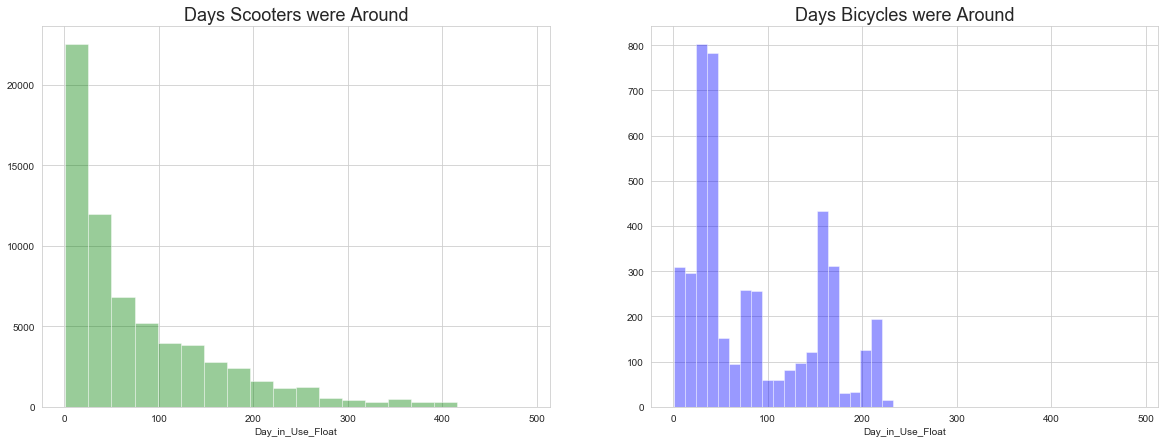

In [10]:
#Note losts of assumptions are made as I don't know how the Device ID's were assigned. I am assuming each device has an ID that never changes
f, ax = plt.subplots(1, 2, figsize=(20, 7), sharex=True)
ax[0].set_title('Days Scooters were Around', fontsize=18)
ax[1].set_title('Days Bicycles were Around', fontsize=18)

sns.distplot(df_agg_vehicle.loc[df_agg_vehicle['Vehicle'] == 'scooter']['Day_in_Use_Float'], bins=20, ax=ax[0], color='green', kde=False)
sns.distplot(df_agg_vehicle.loc[df_agg_vehicle['Vehicle'] == 'bicycle']['Day_in_Use_Float'], bins=20, ax=ax[1], color='blue', kde=False)


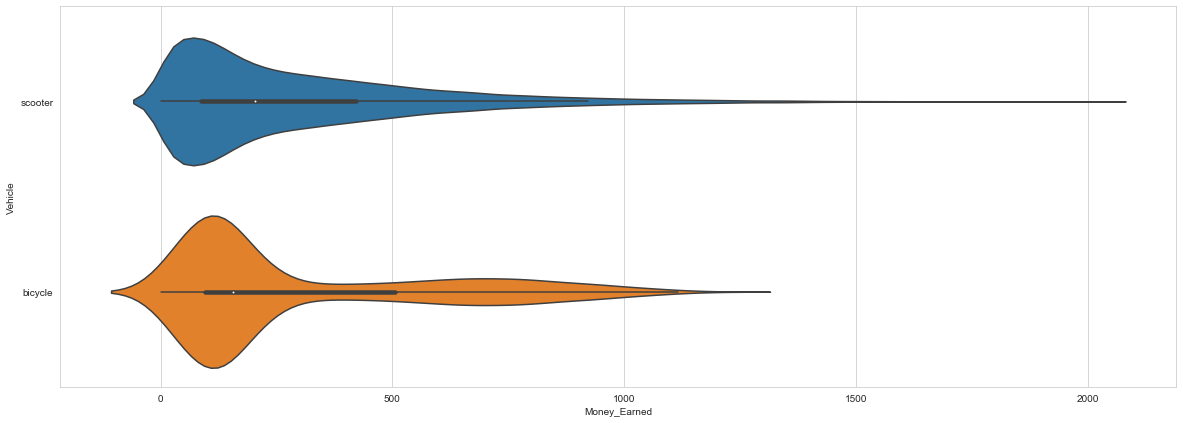

In [13]:
plt.figure(figsize=(20, 7))
sns.violinplot(x='Money_Earned', data = df_agg_vehicle, y='Vehicle')


Devices Notes:
There are lots of devices that earn under 10 dollars and lots of devices that don't last more than 10 days. I assume this is because they get damaged or their Device ID changes after a repair. The average BIRD scooter costs 1300 dollars (https://techcrunch.com/2019/05/08/bird-is-now-selling-its-electric-scooters-directly-to-consumers/) and the bicycles are more expensive.
Few of the vehicles recoup their initial costs and that’s not including the charging costs either.


In [20]:
#Create aggregated table by hour of day
df_agg_time = df.groupby(['Hour','Vehicle Type']).agg(
                                        Total_Rides = ('Cost', 'count'),
                                        Money_Earned = ('Cost', sum),
                                        Total_Meters = ('Trip Distance', sum)                   
)
df_agg_time= df_agg_time.reset_index()

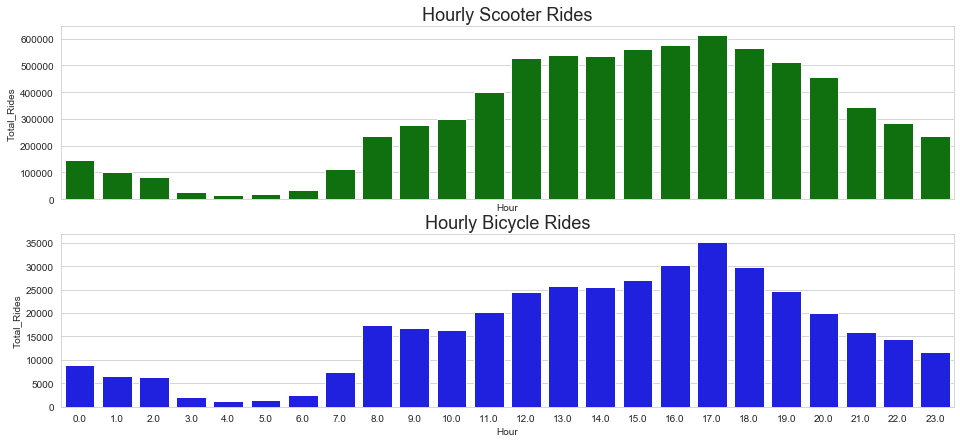

In [21]:
#Times are represened by 24 hour clock
f, ax = plt.subplots(2, 1, figsize=(16, 7), sharex=True)
ax[0].set_title('Hourly Scooter Rides', fontsize=18)
ax[1].set_title('Hourly Bicycle Rides', fontsize=18)

sns.barplot(data=df_agg_time[df_agg_time['Vehicle Type'] == 'scooter'], x='Hour', y='Total_Rides', ax=ax[0], color='green')
sns.barplot(data=df_agg_time[df_agg_time['Vehicle Type'] == 'bicycle'], x='Hour', y='Total_Rides', ax=ax[1], color='blue')

Hour of Day:
Most rides occur in the evening and coincide with rush hour.

In [24]:
#Aggregated table by Day of Week
df_agg_dow = df.groupby(['Day of Week','Vehicle Type']).agg(
                                        Total_Rides = ('Cost', 'count'),
                                        Money_Earned = ('Cost', sum),
                                        Total_Meters = ('Trip Distance', sum)                   
)
df_agg_dow = df_agg_dow.reset_index()
DOW_dict= {'0': 'Sunday',
           '1': 'Monday',
           '2': 'Tuesday',
           '3': 'Wednesday',
           '4': 'Thursday',
           '5': 'Friday',
           '6': 'Saturday',
          }
df_agg_dow['Day of Week'] = df_agg_dow['Day of Week'].replace(DOW_dict)

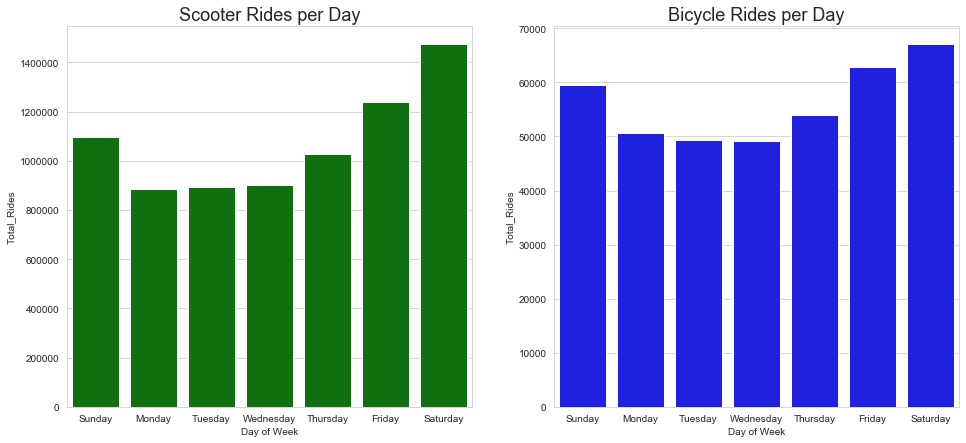

In [25]:
#Times are represened by 24 hour clock
f, ax = plt.subplots(1, 2, figsize=(16, 7), sharex=True)
ax[0].set_title('Scooter Rides per Day', fontsize=18)
ax[1].set_title('Bicycle Rides per Day', fontsize=18)

sns.barplot(data=df_agg_dow[df_agg_dow['Vehicle Type'] == 'scooter'], x='Day of Week', y='Total_Rides', ax=ax[0], color='green')
sns.barplot(data=df_agg_dow[df_agg_dow['Vehicle Type'] == 'bicycle'], x='Day of Week', y='Total_Rides', ax=ax[1], color='blue')

Day of Week:
I thought that the vehicles would be used more on the weekdays for commutes to work but it seems there are more rentals on the weekends. This is probably because they are still viewed as a fun, cruising vehicle rather than mode of transport to and from work.


In [26]:
df_agg_month = df.groupby(['Month','Year','Vehicle Type']).agg(
                                        Total_Vehicles = ('Device ID', 'nunique'),
                                        Total_Rides = ('Cost', 'count'),
                                        Money_Earned = ('Cost', sum),
                                        Total_Meters = ('Trip Distance', sum)                   
)

df_agg_month= df_agg_month.reset_index()
df_agg_month = df_agg_month.sort_values(by=['Year', 'Month', 'Vehicle Type'])


df_agg_month['Date'] = df_agg_month['Month'].map(str)+ '-' +df_agg_month['Year'].map(str)
df_agg_month['Date'] = pd.to_datetime(df_agg_month['Date'], format='%m.0-%Y.0').dt.strftime('%m-%Y')


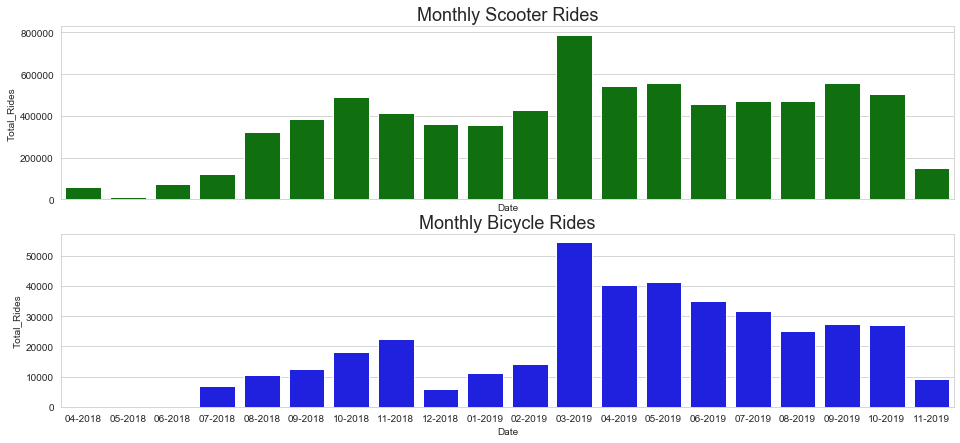

In [27]:
# Monthly plots: Note as time goes on more vehicles were added and 11-2019 is unfinished

f, ax = plt.subplots(2, 1, figsize=(16, 7), sharex=True)
ax[0].set_title('Monthly Scooter Rides', fontsize=18)
ax[1].set_title('Monthly Bicycle Rides', fontsize=18)

sns.barplot(data=df_agg_month[df_agg_month['Vehicle Type'] == 'scooter'], x='Date', y='Total_Rides', ax=ax[0], color='green')
sns.barplot(data=df_agg_month[df_agg_month['Vehicle Type'] == 'bicycle'], x='Date', y='Total_Rides', ax=ax[1], color='blue')

Month:
I would think that there would be less rentals in the winters but Austin is pretty warm year round so there seems to be not much of a change month to month. I would like to see how the frequency of use changes in a city like New York month to month.

 

In [28]:
#https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts
fp = '/Users/arangwala/Documents/Scooter_Data/tl_2010_48_tract10/tl_2010_48_tract10.shp'
blocks = gpd.read_file(fp)

In [29]:
#The dataframe is massive so let's just cut down to the locations I need
blocks_tx = blocks
blocks_453 = blocks[blocks['COUNTYFP10']=='453']

In [30]:
#Aggregate Money earned from ride in a new table attached to start location
df['Census Tract Start'].nunique()
df_census_start = df.groupby('Census Tract Start')['Cost'].agg(['sum', 'count'])

In [31]:
#Combine tables
#Reset index so you can name the column that matches the geo table
df_census_start.reset_index(inplace=True)
df_census_start['GEOID10'] = df_census_start['Census Tract Start']

merged_df = blocks_453.merge(df_census_start, on='GEOID10')
merged_df = merged_df.rename(columns= {'sum': 'Sum', 'count': 'Count'})

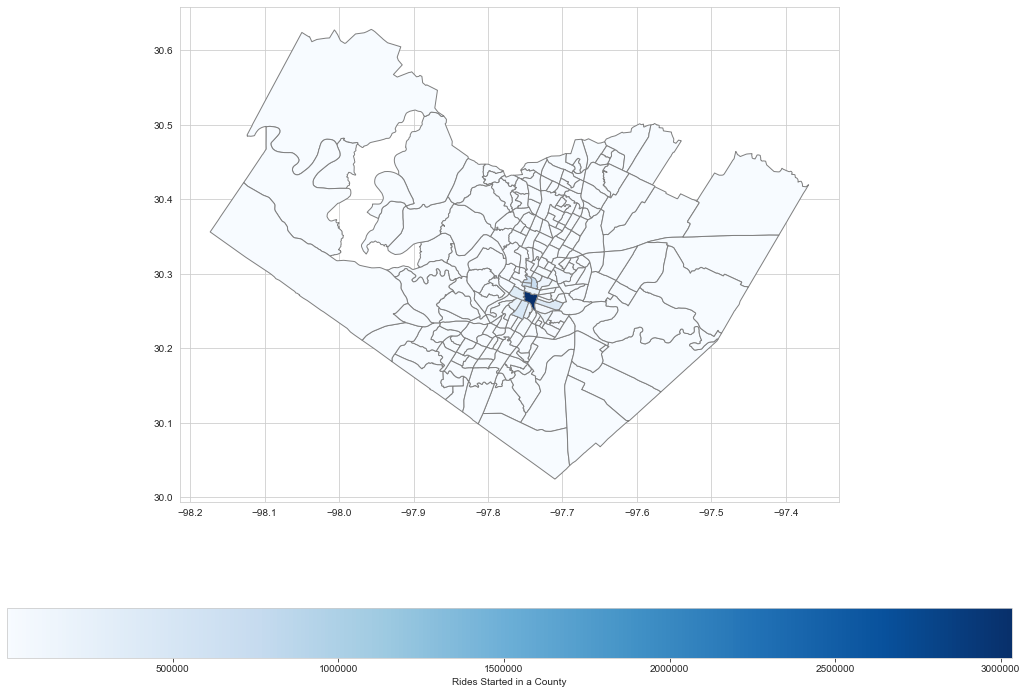

In [32]:
fig, ax = plt.subplots(figsize = (18,13))
#ctx.add_basemap(ax)
#ax.set_xlim(-97.79, -97.675)
#ax.set_ylim(30.22, 30.31)
merged_df.plot(column = 'Count', 
                         ax=ax, 
                         legend=True,
                         cmap='Blues',
                         edgecolor='gray',
                         legend_kwds={'label': "Rides Started in a County",
                        'orientation': "horizontal"}
                        )

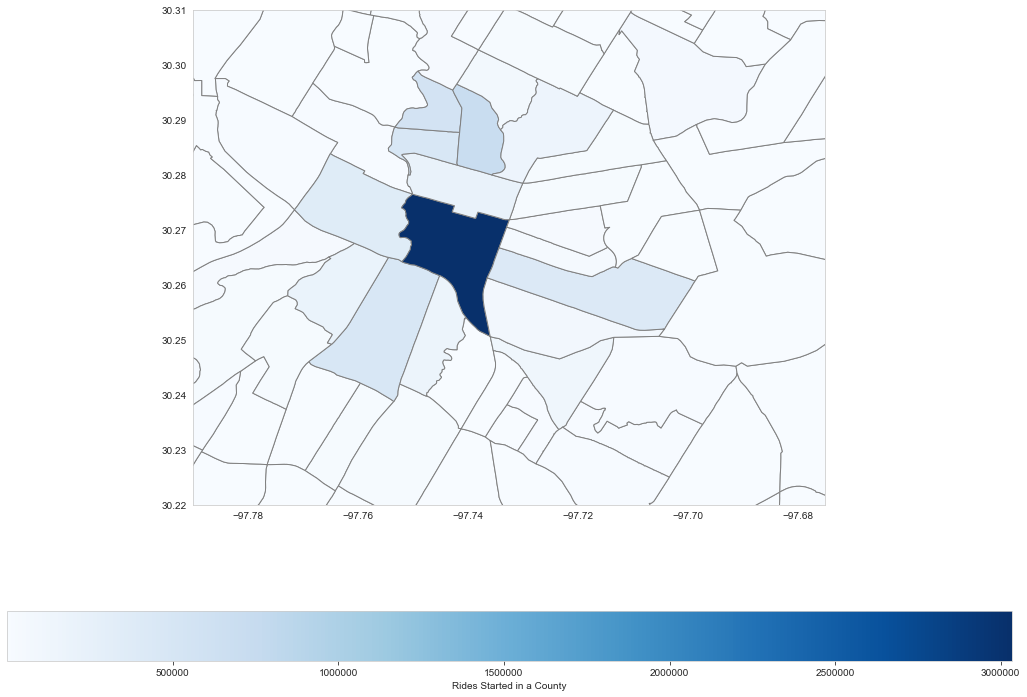

In [33]:
#Time to zoom in
fig, ax = plt.subplots(figsize = (18,13))
ax.set_xlim(-97.79, -97.675)
ax.set_ylim(30.22, 30.31)
merged_df.plot(column = 'Count', 
                         ax=ax, 
                         legend=True,
                         cmap='Blues',
                         edgecolor='gray',
                         legend_kwds={'label': "Rides Started in a County",
                        'orientation': "horizontal"}
                        )

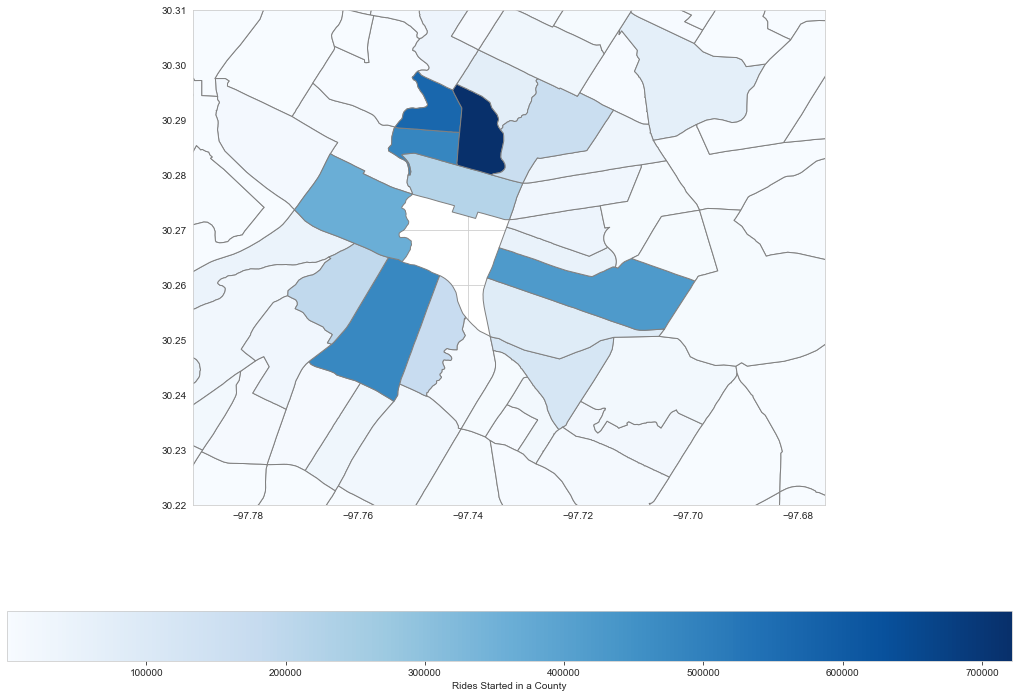

In [34]:
#The vast majority of rides happen in one district so let's remove that one to get a better picture of the others
merged_df_nooutlie = merged_df[merged_df['GEOID10'] != '48453001100']

fig, ax = plt.subplots(figsize = (18,13))
ax.set_xlim(-97.79, -97.675)
ax.set_ylim(30.22, 30.31)
merged_df_nooutlie.plot(column = 'Count', 
                         ax=ax, 
                         legend=True,
                         cmap='Blues',
                         edgecolor='gray',
                         legend_kwds={'label': "Rides Started in a County",
                        'orientation': "horizontal"}
                        )

As expected the vast majority of money with these scooters is made downtown. In second place is the huge UT Austin college campus and surround areas. 

Next, Let's compare the use of scooters in downtown with that of the university.
Specifically, I want to see the times that the scooters are used most often. I hypothesize they are utilized during rush hour more downtown (for commutes) and spread out more on campus (college classes are spread throughout the day and college kids probably use them more for recreation)